<a href="https://colab.research.google.com/github/Gabriele-tomai00/Image_classifier/blob/main/BOW_CV_in_fieri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Requirments and setting operations#

In [ ]:
#librerie
import os
from PIL import Image
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats
from sklearn import metrics
import random as rd
from sklearn.svm import SVC
from google.colab import drive
from sklearn.utils import shuffle
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


In [ ]:
!pip install kneed
from kneed import KneeLocator

In [ ]:
drive.mount('/content/drive/', force_remount=True)


Mounted at /content/drive/


In [ ]:
# Funzione per leggere le immagini e creare una lista di etichette
def load_images_labels(principal_folder):
    """
      Loads valid image file paths and their associated labels from a structured directory.

      Parameters:
        principal_folder (str): Path to the main directory containing labeled subfolders.
                                Each subfolder represents a class label and contains image files.

      Returns:
          images (list of str): List of valid image file paths.
          labels (list of str): List of labels corresponding to each image, based on subfolder names.
    """

    labels = []
    images = []

    for folder in os.listdir(principal_folder):
        folder_path = os.path.join(principal_folder, folder)

        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)

                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                    try:
                        img = Image.open(file_path)
                        img.verify()

                        # Save image and its label
                        images.append(file_path)
                        labels.append(folder)
                    except (IOError, SyntaxError):
                        # If the image is corrupted, ignore it
                        continue

    return images, labels


In [ ]:
# Upload image training
folder_training = '/content/drive/MyDrive/CV_progetto2/train'
images_training, train_labels  = load_images_labels(folder_training)

In [ ]:
# Labels
labels = np.unique(train_labels)
print(labels)

['Bedroom' 'Coast' 'Forest' 'Highway' 'Industrial' 'InsideCity' 'Kitchen'
 'LivingRoom' 'Mountain' 'Office' 'OpenCountry' 'Store' 'Street' 'Suburb'
 'TallBuilding']


In [ ]:
# Loading test images
folder_test = '/content/drive/MyDrive/CV_progetto2/test'
images_test, test_labels  = load_images_labels(folder_test)

#Assignment 1#
build a visual vocabulary:


*   sample many (10K to 100K) SIFT descriptors from the images of
the training set (you either use a detector or sample on a grid in the
scale-space);
*  cluster them using k-means (the choice of the number of clusters is
up to you, and you should experiment with different values, but you
could start with a few dozens);
*  collect (and save for future use) the clusters’ centroids which repre-
sent the k 128-dimensional visual words.

##**Comments**


---


The images are converted to grayscale because SIFT descriptors do not explicitly use color information. Texture and shape are not influenced by color, so it is sufficient to use a single channel, which results in lower memory usage and better computational efficiency.
For each image, 60 keypoints are detected, so with 1,500 images, we obtain $60*1500=90000$ descriptors that can be used to compute the visual vocabulary.

In [ ]:
# SIFT descriptors
all_descriptors = []
k_p = 60  #60*1500 = 90000 descriptors in total
for image_path in images_training:
    # grey scale image conversion
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    sift = cv2.SIFT_create(k_p)
    keypoints, descriptors = sift.detectAndCompute(image, None)
    if descriptors is not None:
        all_descriptors.append(descriptors)
all_descriptors = np.vstack(all_descriptors)

The number of visual words was determined using a grid search with the K-Means algorithm. The following metrics were used to identify a good number of clusters:  

*   Inertia: Measures the internal cohesion of the clusters. Lower inertia
indicates higher cohesion, but the value naturally decreases as the number of clusters increases.
*   Silhouette Score: Measures the separation between clusters. It evaluates how well each point fits within its assigned cluster compared to others.

To find the optimal value of k, it is necessary to look for a high silhouette score and low inertia, balancing both compactness and separation.

The best value at this point is chosen to be k = 48



For k = 36 | Silhouette Score = 0.0536
For k = 48 | Silhouette Score = 0.0503
For k = 60 | Silhouette Score = 0.0488
For k = 72 | Silhouette Score = 0.0466
For k = 84 | Silhouette Score = 0.0467
For k = 96 | Silhouette Score = 0.0438
For k = 108 | Silhouette Score = 0.0418
For k = 120 | Silhouette Score = 0.0423
For k = 132 | Silhouette Score = 0.0414
For k = 144 | Silhouette Score = 0.0411
For k = 156 | Silhouette Score = 0.0397
For k = 168 | Silhouette Score = 0.0396
For k = 180 | Silhouette Score = 0.0394
For k = 192 | Silhouette Score = 0.0387
For k = 204 | Silhouette Score = 0.0376
For k = 216 | Silhouette Score = 0.0376
For k = 228 | Silhouette Score = 0.0366

--- Summary ---
Optimal k by Elbow Method: 108
Optimal k by Silhouette Score: 36


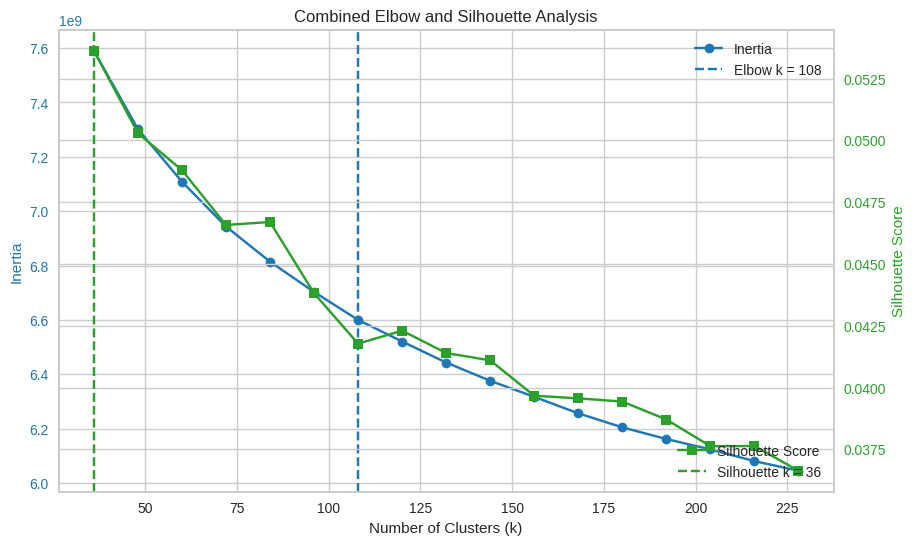

In [ ]:
# k testing values
k_list = [x for x in range(36, 240, 12)]

inertia_values = []
silhouette_scores = []

for k in k_list:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(all_descriptors)

    # Inertia (cohesion)
    inertia_values.append(kmeans.inertia_)

    # Silhouette score (separation)
    score = silhouette_score(all_descriptors, kmeans.labels_)
    silhouette_scores.append(score)

    print(f"For k = {k} | Silhouette Score = {score:.4f}")

# Find the knee by KneeLocator
kneedle = KneeLocator(k_list, inertia_values, curve='convex', direction='decreasing')
elbow_k = kneedle.knee

# Find the max Silhouette Score and its k value
best_silhouette_k = k_list[silhouette_scores.index(max(silhouette_scores))]

print("\n--- Summary ---")
print(f"Optimal k by Elbow Method: {elbow_k}")
print(f"Optimal k by Silhouette Score: {best_silhouette_k}")

# Elbow + Silhouette
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia', color=color)
ax1.plot(k_list, inertia_values, marker='o', color=color, label='Inertia')
ax1.axvline(elbow_k, color=color, linestyle='--', label=f'Elbow k = {elbow_k}')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper right')

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(k_list, silhouette_scores, marker='s', color=color, label='Silhouette Score')
ax2.axvline(best_silhouette_k, color=color, linestyle='--', label=f'Silhouette k = {best_silhouette_k}')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='lower right')

plt.title('Combined Elbow and Silhouette Analysis')
plt.show()


In [ ]:
#Cluster descriptors per visual words (vocabulary)
k = 108  # fai altre prove se vuoi (48)
kmeans = KMeans(n_clusters=k)
kmeans.fit(all_descriptors)
visual_words = kmeans.cluster_centers_

#Assignment 2#
Represent each image of the training set as a normalized histogram having
k bins, each corresponding to a visual word; possibility is to perform a
rather dense sampling in space and scale; another possibility is to use the
SIFT detector to find the points in scale-space where the descriptor is
computed. In any case, each computed descriptor will increase the value
of the bin corresponding to the closest visual word.

**Comments**


---



In [ ]:
def compute_histograms(images, visual_words):
    """
    Computes a normalized visual word histogram for each image in the dataset.

    Parameters:
        images (list of str): List of file paths to the images.
        visual_words (ndarray of shape (k, 128)):
            Array containing k visual words (cluster centroids) in SIFT descriptor space.

    Returns:
        histograms (list of ndarray): List of 1D histograms, one per image,
            representing the frequency of each visual word (normalized).
    """
    v = visual_words.shape[0]
    histograms = []

    for image_path in images:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        sift = cv2.SIFT_create()
        keypoints, descriptors = sift.detectAndCompute(image, None)

        hist = np.zeros(v)

        if descriptors is not None:
            # descriptors: (n, 128), visual_words: (k, 128)
            distances = np.linalg.norm(descriptors[:, np.newaxis, :] - visual_words[np.newaxis, :, :], axis=2) #distances ha dimensioni (n,k)
            # Fond for each descriptor the index of the closest visual word
            closest_words = np.argmin(distances, axis=1)
            # Increments the score of the bin = visual word,
            for idx in closest_words:
                hist[idx] += 1

        # Normalization
        if np.sum(hist) > 0:
            hist = hist / np.sum(hist)

        histograms.append(hist)

    return histograms


In [ ]:
# Compute the histograms of visual words frequency for all the trainig images
train_histograms = compute_histograms(images_training,visual_words)

In [ ]:
def plot_bow_histogram(hist, title="Istogramma BoW", save_path=None, show_values=False):
    """
    Plots a histogram of visual word frequencies.

    Args:
        hist (np.ndarray): histogram (array 1D).
        title (str): title of the graph.
        save_path (str): If specified, save the image as file.
        show_values (bool): Se True, shows values on top of the bars.
    """
    k = len(hist)
    x = np.arange(k)

    plt.figure(figsize=(30, 10))
    bars = plt.bar(x, hist, color='skyblue', edgecolor='black')

    if show_values:
        for bar in bars:
            height = bar.get_height()
            if height > 0.01:  # to avoid not useful labels
                plt.text(bar.get_x() + bar.get_width() / 2.0, height,
                         f'{height:.2f}', ha='center', va='bottom', fontsize=8)

    plt.xlabel("Visual word ID")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.xticks(x)  #
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Istogramma salvato in: {save_path}")
    else:
        plt.show()

    plt.close()


In [ ]:
#plot a single histogram
#plot_bow_histogram(train_histograms[7])

#Assignment 3#

Employ a nearest neighbor classifier and evaluate its performance:


*   compute the normalized histogram for the test image to be classified;
*   assign to the image the class corresponding to the training image
having the closest histogram.
*   repeat for all the test images and build a confusion matrix.

##**Comments**


---
It is necessary to convert the text labels into numeric form because the KNeighborsClassifier requires numerical input for the labels.

A grid search approach was used to find the optimal number of neighbors (k).
With a visual vocabulary of 48 visual words, the model reaches a performance plateau at around 38% accuracy and 37% macro F1-score for k = 21.

Some classes are easier to classify correctly than others:
*  Forest achieves over 200 correct predictions,
*  Street over 140,
*  Suburb more than 130.

In contrast, other categories are more challenging. For example, Kitchen is often confused with Office or Living Room, with about 25 misclassifications for each and only around 9 correct predictions.

If we choose instead a visual vocabulary of 108 terms and k = 15 (performance plateau at around 37% accuracy and 33% macro F1-score for k = 21) the model gives:


*   almost a perfect classification of Forest images (218/228)
*   almost a perfect classification of Suburbs images (131/141)
*   a good performance on Store image classification (159 correct classifications)

but also a really bad performance on:



*   Street images are classified as Store twice the times (86) of the correct classification (46)
*   OpenCountry is misclassified as Forest most of the times
*   Industrial images (37 correct classifications) too, are misclassified twice the time as Store (66)

It's interisting to point out that Kitchen is still the most difficult class to manage in fact only 9 images are correctly identified




In [ ]:
# Compute the histograms of visual words frequency for all the test images
test_histograms = compute_histograms(images_test, visual_words)

In [ ]:
#label encoding training_labels text-numbers
label_encoder = LabelEncoder()
labels_train_encoded = label_encoder.fit_transform(train_labels)

In [ ]:
#shuffle data
indices = list(range(len(train_labels)))
rd.shuffle(indices)
train_histograms = [train_histograms[i] for i in indices]
labels_train_encoded = [labels_train_encoded[i] for i in indices]
indices_test = list(range(len(test_labels)))
rd.shuffle(indices_test)
test_histograms = [test_histograms[i] for i in indices_test]
test_labels = [test_labels[i] for i in indices_test]

k = 5, accuracy = 0.3692, macro-F1 = 0.3326
k = 7, accuracy = 0.3709, macro-F1 = 0.3341
k = 9, accuracy = 0.3722, macro-F1 = 0.3363
k = 11, accuracy = 0.3742, macro-F1 = 0.3372
k = 13, accuracy = 0.3739, macro-F1 = 0.3372
k = 15, accuracy = 0.3739, macro-F1 = 0.3367
k = 17, accuracy = 0.3695, macro-F1 = 0.3310
k = 19, accuracy = 0.3719, macro-F1 = 0.3324
k = 21, accuracy = 0.3715, macro-F1 = 0.3330
k = 23, accuracy = 0.3678, macro-F1 = 0.3273
k = 25, accuracy = 0.3642, macro-F1 = 0.3217
k = 27, accuracy = 0.3621, macro-F1 = 0.3184
k = 29, accuracy = 0.3638, macro-F1 = 0.3225


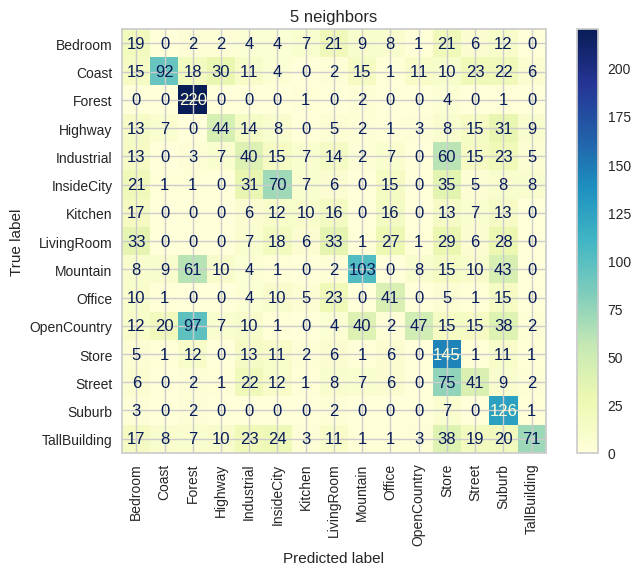

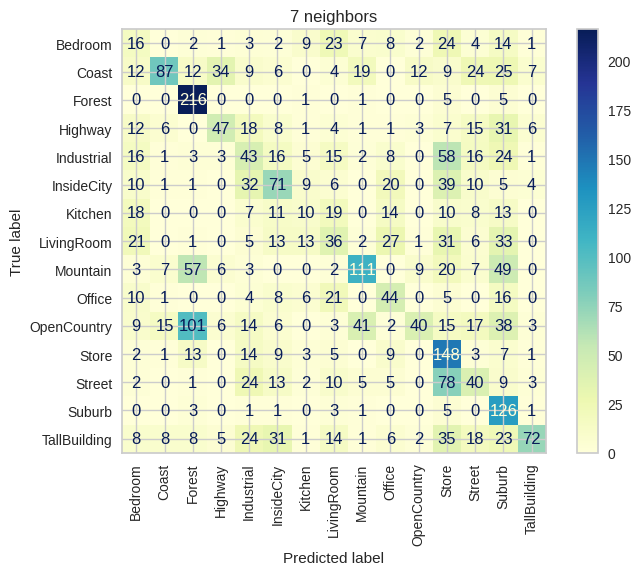

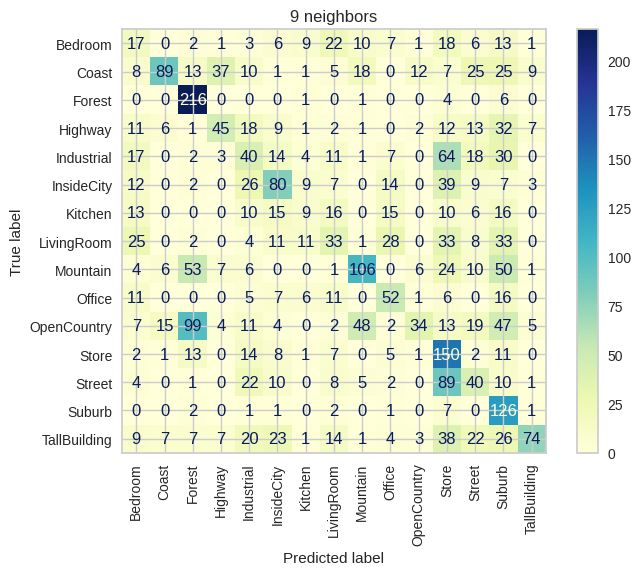

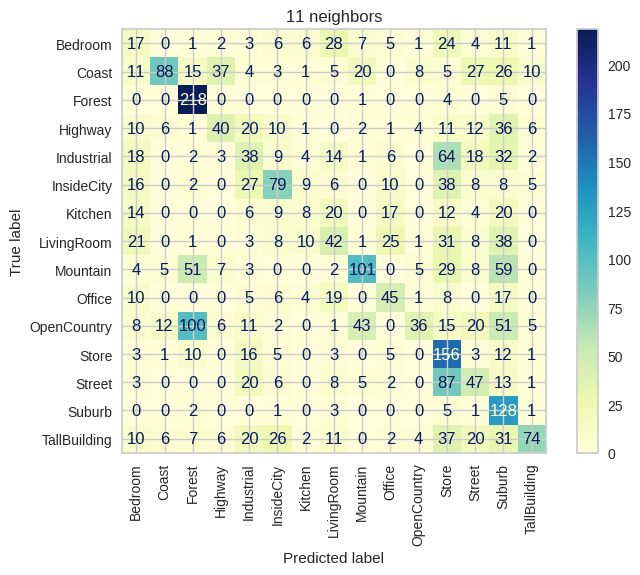

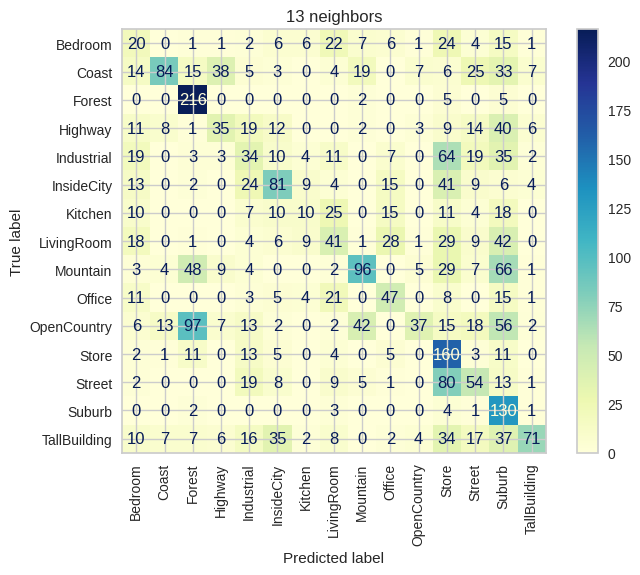

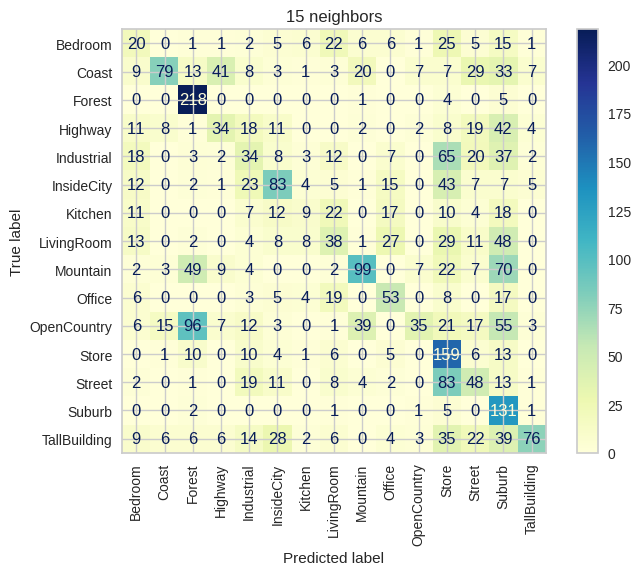

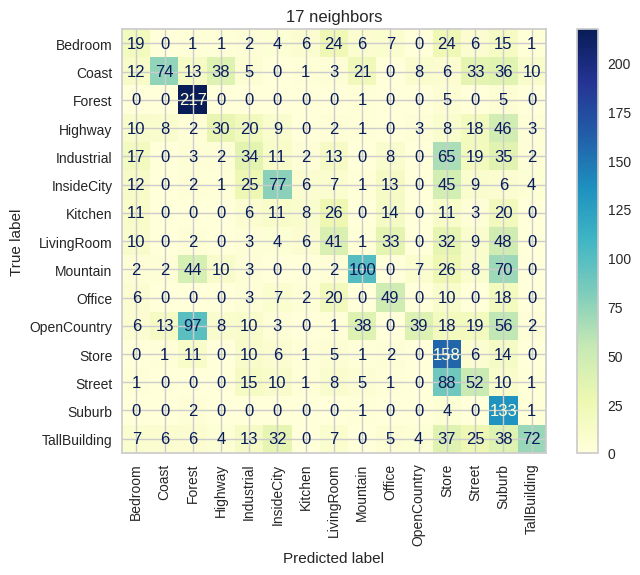

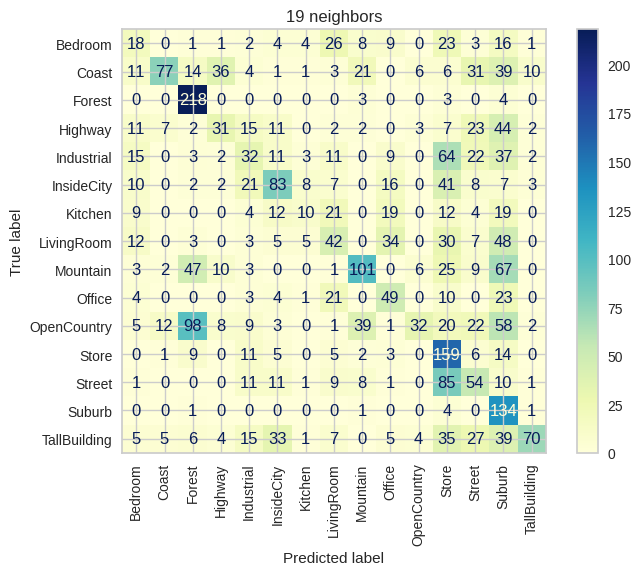

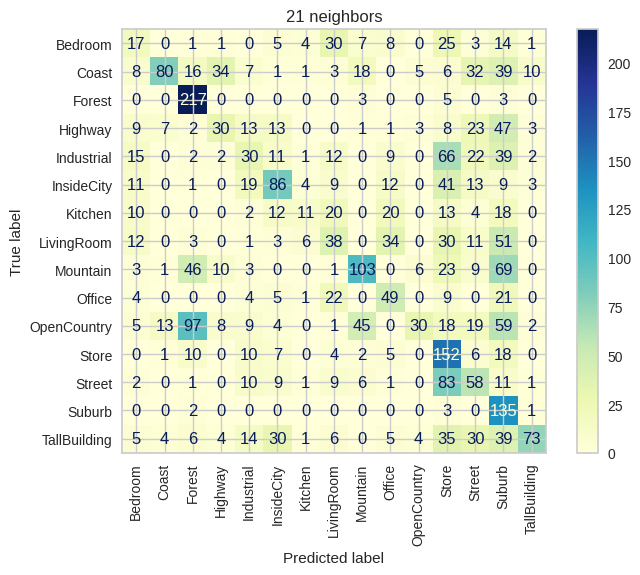

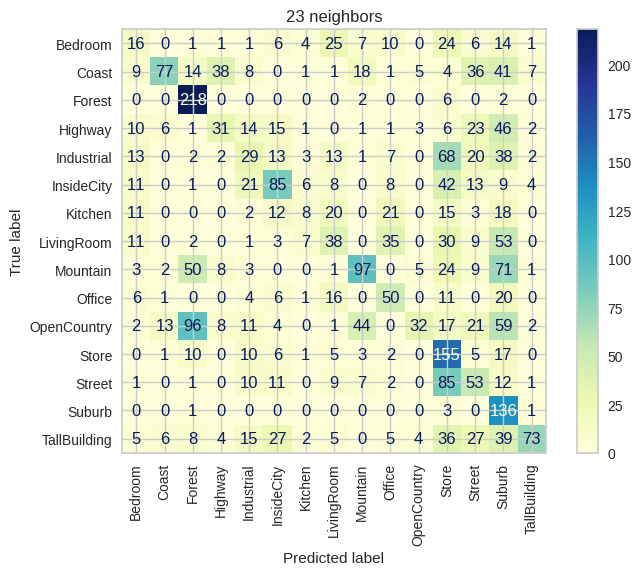

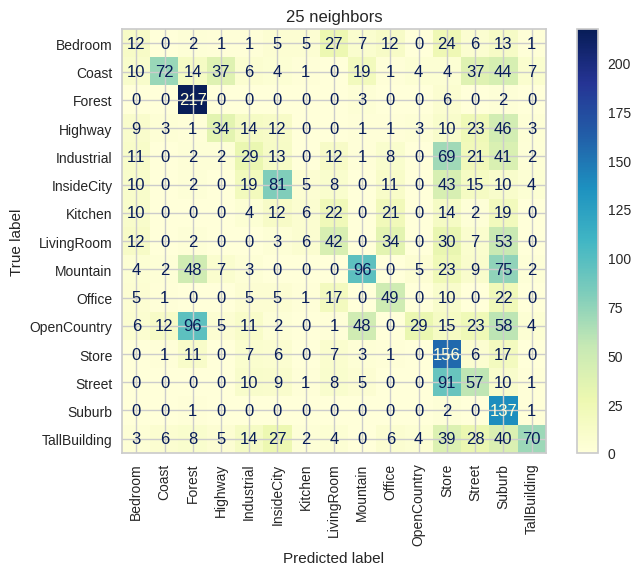

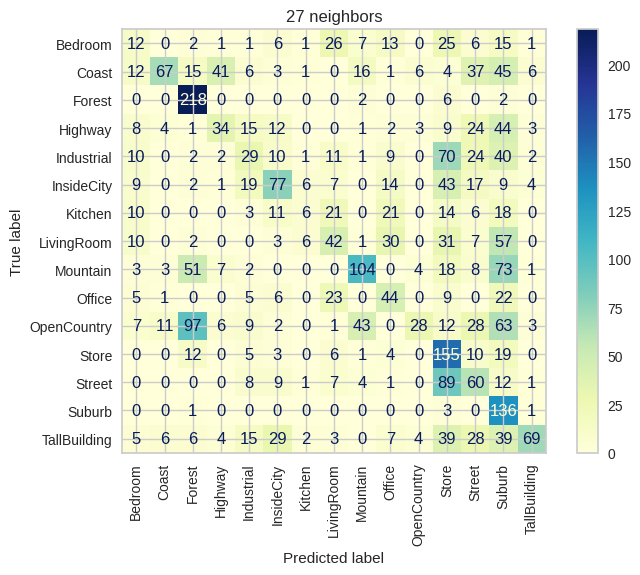

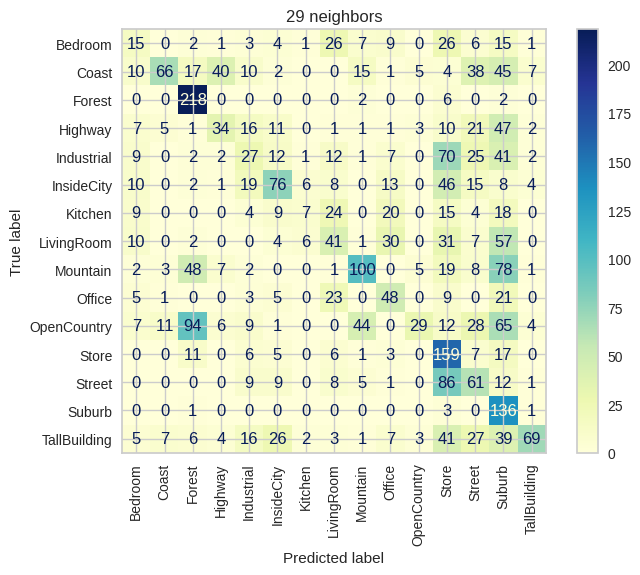

In [ ]:
for k in range(5,30,2):
#training
  neigh = KNeighborsClassifier(n_neighbors=k) # Mikownski distance
  neigh.fit(train_histograms, labels_train_encoded)
#test phase
  predicted_labels = neigh.predict(test_histograms)
# confusion matrix
  predicted_labels = label_encoder.inverse_transform(predicted_labels)
  cm_display = metrics.ConfusionMatrixDisplay.from_predictions(test_labels, predicted_labels, display_labels=labels,xticks_rotation='vertical',cmap='YlGnBu')
  cm_display.ax_.set_title(("{} neighbors").format(k))
  acc = accuracy_score(test_labels, predicted_labels)
  f1 = f1_score(test_labels, predicted_labels, average='macro')
  print(f"k = {k}, accuracy = {acc:.4f}, macro-F1 = {f1:.4f}")

k = 15, accuracy = 0.3739, macro-F1 = 0.3367


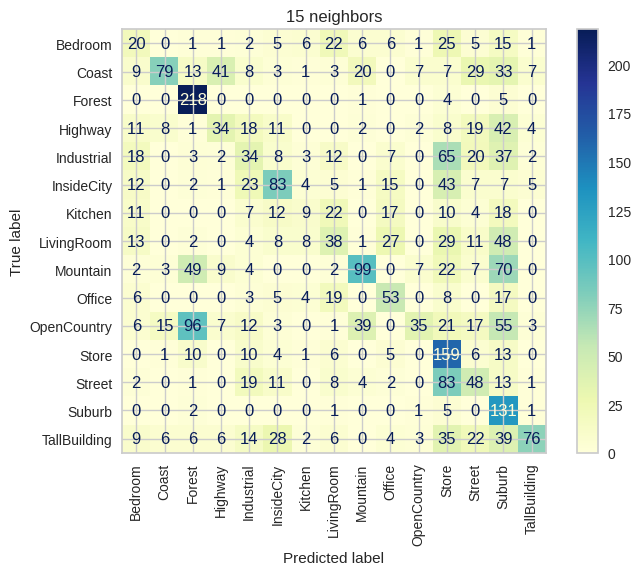

In [ ]:
#training
k= 15
neigh = KNeighborsClassifier(n_neighbors=k) # Mikownski distance
neigh.fit(train_histograms, labels_train_encoded)
#test phase
predicted_labels = neigh.predict(test_histograms)
# confusion matrix
predicted_labels = label_encoder.inverse_transform(predicted_labels)
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(test_labels, predicted_labels, display_labels=labels,xticks_rotation='vertical',cmap='YlGnBu')
cm_display.ax_.set_title(("{} neighbors").format(k))
acc = accuracy_score(test_labels, predicted_labels)
f1 = f1_score(test_labels, predicted_labels, average='macro')
print(f"k = {k}, accuracy = {acc:.4f}, macro-F1 = {f1:.4f}")

#Assignment 4#
Train a multiclass linear Support Vector Machine, using the one-vs-rest
approach (you will need to train 15 binary classifiers having the normalized
histograms as the input vectors and positive labels for the “one” class and
negative for the “rest.”)

##**Comments**


---

The One-vs-Rest approach was used. Specifically, the training labels were converted into binary values: 1 indicated the class the SVM was supposed to recognize, while 0 represented all other classes. This resulted in 15 binary classifiers. To evaluate which kernel provided the best results, training was performed multiple times using different kernels: first with a linear kernel, then with an RBF kernel, and finally with a polynomial kernel. The results were compared in the following section using confusion matrices generated from the test dataset.

In [ ]:
# not needed but to be sure:
# train_histograms = compute_histograms(images_training,visual_words)
# test_histograms = compute_histograms(images_test,visual_words)

In [ ]:

# Preprocessing
X_train = np.array(train_histograms)
y_train = np.array(train_labels)
X_train, y_train = shuffle(X_train, y_train, random_state=42)
class_names = np.unique(y_train)
n_classes = len(class_names)


classifiers = []
# One-vs-rest
for class_name in class_names:
    # binary target for each class
    y_binary = (y_train == class_name).astype(int)
    svm = SVC(kernel='poly', probability=True)
    svm.fit(X_train, y_binary)
    classifiers.append(svm)


#Assigment 5
Evaluate the multiclass SVM:
* compute the normalized histogram for the test image to be classified;
* compute the real-valued output of each of the SVMs, using that histogram as input;
* assign to the image the class corresponding to the SVM having the
greatest real-valued output.
* repeat for all the test images and build a confusion matrix.

##Comments


---
the histograms of visual words for each test image have been alredy computed in the previous point.
Different test were conducted for different kernel of the SVM:


*   Linear kernel:
    *   This model performs best for the *Tall Building* and *Inside City* classes (with over 100 correct classifications each).
    *   Overall, the model outperforms the KNN Classifier, although many misclassifications still occur.
*   Rbf kernel:
    *   The *Suburb* class is better classified compared to the other models.
    *   The worst performance is observed for the *Kitchen* and *Living Room* classes.
*   Poly kernel:
    *   The classes *Living Room*, *Mountain*, and *Open Country* are classified better compared to the other models.
    *   The classification of the *Coast* class, on the other hand, is significantly worse, similar to the KNN Classifier model (only 90 correct classifications compared to over 160 in the other models).



Overall, regardless of the kernel used, all SVM models perform better than the KNN Classifier.
The *Forest* class is consistently the best classified across all models, especially by the SVM with a linear kernel.
*Kitchen* is always the least accurately classified class, although SVMs still achieve slightly better results than the KNN classifier.
Based on the confusion matrices, the best-performing models appear to be the SVM with the RBF kernel or the polynomial kernel.


In [ ]:
#test - linear kernel
X_test = np.array(test_histograms)
predictions = []
# scores has as rows the test images and as columns the single classifier, transposition is need to find the max value
scores = np.array([clf.decision_function(X_test) for clf in classifiers]).T
for i in range(len(X_test)):
    predicted_label = np.argmax(scores[i])
    predictions.append(predicted_label)

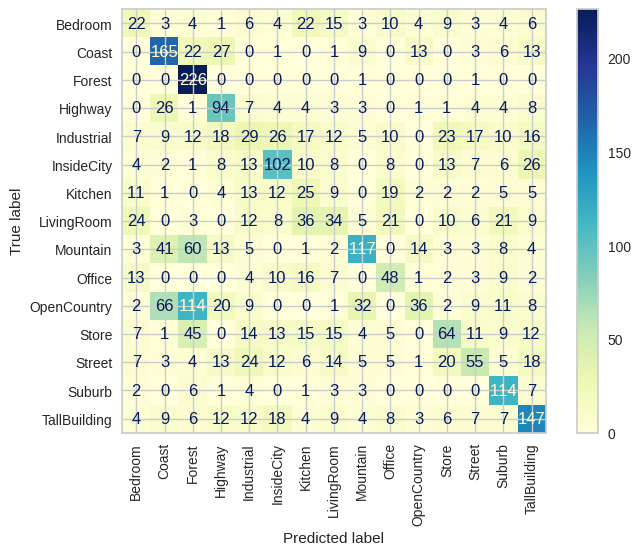

In [ ]:
# confusion matrix
y_pred_labels = [class_names[i] for i in predictions]
test_labels = list(test_labels)
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(test_labels,y_pred_labels , display_labels=labels,xticks_rotation='vertical',cmap='YlGnBu')

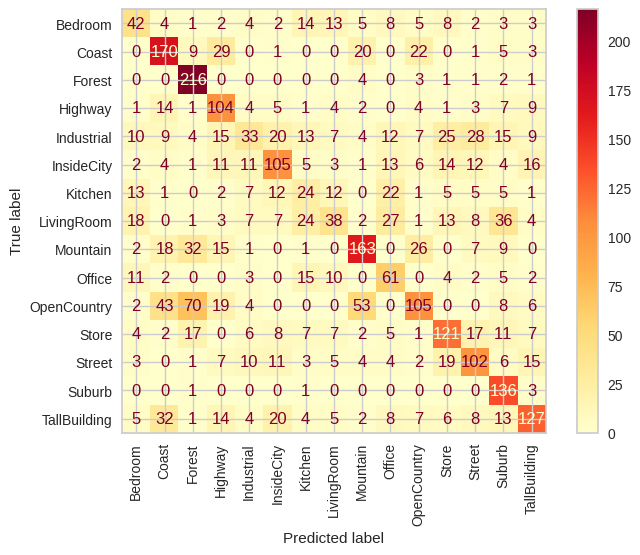

In [ ]:
#test - rbf kernel
X_test = np.array(test_histograms)
predictions = []
# scores has as rows the test images and as columns the single classifier, transposition is need to find the max value
scores = np.array([clf.decision_function(X_test) for clf in classifiers]).T
for i in range(len(X_test)):
    predicted_label = np.argmax(scores[i])
    predictions.append(predicted_label)
# confusion matrix
y_pred_labels = [class_names[i] for i in predictions]
test_labels = list(test_labels)
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(test_labels,y_pred_labels , display_labels=labels,xticks_rotation='vertical',cmap='YlOrRd')

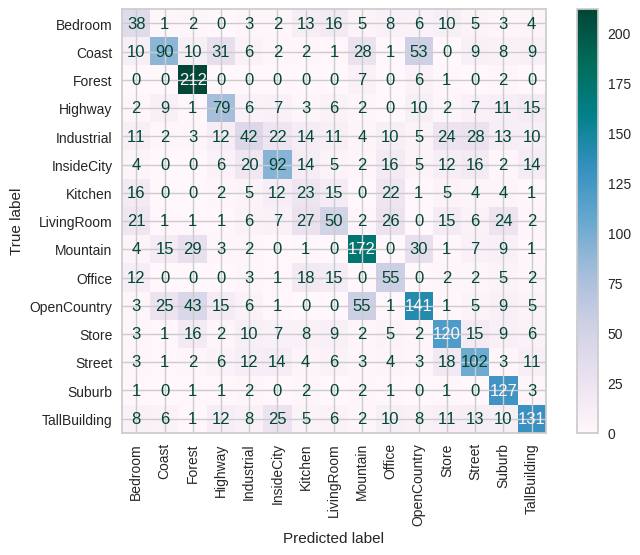

In [ ]:
#test - poly kernel
X_test = np.array(test_histograms)
predictions = []
# scores has as rows the test images and as columns the single classifier, transposition is need to find the max value
scores = np.array([clf.decision_function(X_test) for clf in classifiers]).T
for i in range(len(X_test)):
    predicted_label = np.argmax(scores[i])
    predictions.append(predicted_label)
# confusion matrix
y_pred_labels = [class_names[i] for i in predictions]
test_labels = list(test_labels)
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(test_labels,y_pred_labels , display_labels=labels,xticks_rotation='vertical',cmap='PuBuGn')

#Optionally#

##Point 6


---


Optionally, you could train the SVM using a generalized Gaussian kernel
(Lecture 7) based on the χ^2 distance;

da aggiunger grid search per A e tuning vari ma lo scheltro è giusto

###**Comments**
In the next setion to use a generalized Gaussian kernel, it was necessary to precompute the kernel itself. So the Chi square kernel was define as it follow:
$k(x,x') = exp[\frac{1}{A}\frac{(x'-x)^2}{x'+x}]$

The next step is the implementation of a grid search to tune the parameter A.
The better value for A =.
It's possible to see that this kernel improves the classification of ? classes


In [ ]:
def chi_square_kernel(x_i, x, eps=1e-10, A=0.25):
    """
    Computes the Chi-square kernel between two vectors x_i and x.
    """
    chi_square_dist = np.sum(((x_i - x)**2) / (x_i + x + eps))   #eps is to avoid 0/0
    return np.exp(-chi_square_dist/A)

In [ ]:
#training SVM
X_train = np.array(train_histograms)
K_train = np.array([[chi_square_kernel(x_i, x_j) for x_j in X_train] for x_i in X_train])

In [ ]:
# Preprocessing
X_train = np.array(train_histograms)
y_train = np.array(train_labels)
X_train, y_train = shuffle(X_train, y_train, random_state=42)
class_names = np.unique(y_train)
n_classes = len(class_names)


classifiers_chi = []
# One-vs-rest
for class_name in class_names:
    # binary target for each class
    y_binary = (y_train == class_name).astype(int)
    svm = SVC(kernel='precomputed', probability=True)
    svm.fit(K_train, y_binary)
    classifiers_chi.append(svm)


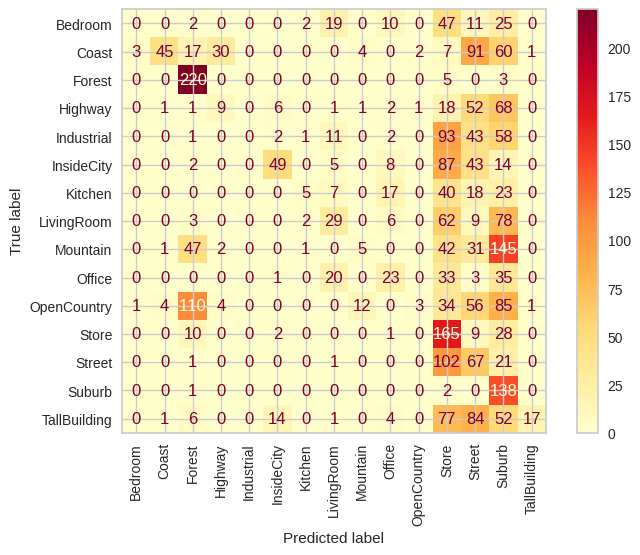

In [ ]:
X_test = np.array(test_histograms)

# the kernel is computed between training and test data
K_test = np.array([[chi_square_kernel(x_test, x_train) for x_train in X_train] for x_test in X_test])

all_scores = np.array([clf.decision_function(K_test) for clf in classifiers_chi]).T
predicted_indices = np.argmax(all_scores, axis=1)
y_pred_labels = [class_names[i] for i in predicted_indices]
test_labels = list(test_labels)

cm_display = metrics.ConfusionMatrixDisplay.from_predictions(test_labels,y_pred_labels, display_labels=class_names,xticks_rotation='vertical', cmap='YlOrRd')


In [ ]:
# Support vector extraction and computation of the kernel
X_test = np.array(test_histograms)
predictions = []
for svm in classifiers_chi:
  support_vectors_indices = svm.support_
  support_vectors = X_train[support_vectors_indices]
  K_test = np.array([[chi_square_kernel(x_i, x_j) for x_j in X_test] for x_i in support_vectors])

##Point 7


---

optionally, you could implement the multiclass SVM using the Error Correcting Output Code approach [Dietterich and Bakiri, 1994, James and
Hastie, 1998];

### **Comments**


---
The Error Correcting Output Code appoach implemented was the one propose by Diettrich and Bakiri. To make possible the algorithm  application the image labels need to be rewritten as binary strings such that the Hamming distance between the columns that form them, as well as between individual columns and the complements of others, is large.
Since we have more than 11 classes, the Randomized Hill Climb algorithm can be implemented.
The Randomized Hill Climb algorithm is given by the following steps:


1.   k random strings of an arbitary lenght L, are generated (L=20)
2.   The most close rows are find computing the Hamming disance for each pair
3.   The most extreme column are found, searching for the extreme value, minimum and maximum Hamming distance between, them.
4.   The intersections between the pair of rows and columns are identified and the bit are modified
5.   The procedure is stopped when a local maximum (Hamming distance) is reached and a couple of random rows and columns are choosen and their distance incremented

the procedure is iterated a fixed number of time, in this cas 100

Multi-class SVM is implemented by default; the SVM function internally already uses a "one-vs-one" strategy.


In [ ]:
def hamming_distance(matrix,min):
  '''
    Hammin distance calculator

    Args (list)

    Return: max_distance(float), i_max = row index, j_max = column index
  '''
  # computing distance between rows
  distances= np.array([
      distance.hamming(
          matrix[i], matrix[j])
          for i in range(matrix.shape[0])
          for j in range(matrix.shape[0])
          if i !=j ])
  if min == True:
    min_distance = np.min(distances)
    min_index = np.argmin(distances)
    i_min = min_index // matrix.shape[0]
    j_min = min_index % matrix.shape[0]
    return min_distance, i_min, j_min
  else:
    max_distance = np.max(distances)
    max_index = np.argmax(distances)
    i_max = max_index // matrix.shape[0]
    j_max = max_index % matrix.shape[0]
    return max_distance, i_max, j_max


In [ ]:
#Randomize Hill Climb
import random
import scipy.spatial.distance as distance
from itertools import combinations

n_class = 15
n_col = 20 # L, strings length
labels_RHC = np.random.randint(0,2,size=(n_class,n_col))
print(labels_RHC)
for l in range (0,100,1):

  # Find the row with minimum Hamming distance
  min_dist_row, i_min, j_min = hamming_distance(labels_RHC,min)

  # Find the columns with maximum Hamming distance (it's possible to choose the min too)
  max_dist_col, i_max, j_max = hamming_distance(labels_RHC.T,max)

  # Minimum Hamming distance of all matrix is choosen as a trheshold to check the improvment of the iteration:
  min_dist_col, i_mc, j_mc = hamming_distance(labels_RHC,min)
  min_dist = min(min_dist_row,min_dist_col)

  # Choose 2 of 4 common terms and modify them (change all of them doesn't means no change hamming distance  is not affected then)
  common_bits = [(i_min,j_max),(i_min,i_max),(j_min,j_max),(j_min,i_max)]
  print(common_bits)
  bit_combinations = list(combinations(common_bits, 2))
  indx = 0
  for pair in bit_combinations:
    (i, j),(k,l) = pair
    indx += 1
    labels_RHC[i,j] =  1 - labels_RHC[i,j]
    labels_RHC[k,l] =  1 - labels_RHC[k,l]
    min_row, i_mr, j_mr = hamming_distance(labels_RHC,min)
    min_col, i_mc, j_mc = hamming_distance(labels_RHC.T,min)
    new_min_dist = min(min_row,min_col)
    if new_min_dist <= min_dist and indx==len(bit_combinations):
      #print("massimo locale {},{}".format(new_min_dist,min_dist))
      i = np.random.randint(0,n_class-1)
      j = np.random.randint(0,n_class-1)
      k = np.random.randint(0,n_col-1)
      l = np.random.randint(0,n_col-1)
      labels_RHC[i,k] =  1 - labels_RHC[i,k]
      labels_RHC[j,k] =  1 - labels_RHC[j,k]
      labels_RHC[i,l] =  1 - labels_RHC[i,l]
      labels_RHC[j,l] =  1 - labels_RHC[j,l]
    else:
      continue

print(labels_RHC)



In [ ]:
# MSVM implementation
from sklearn.datasets import make_multilabel_classification

# RHC conversion
label_to_index = {label: i for i, label in enumerate(labels)}
train_label_encoded = np.array([
    labels_RHC[label_to_index[train_label]] for train_label in train_labels
])

# training
svc = SVC(kernel='linear')
svc.fit(train_histograms, train_label_encoded)

# test
Y_pred = svc.predict(test_histograms)


In [ ]:
# encode test labels
test_label_encoded = np.array([
    labels_RHC[label_to_index[label]] for label in test_labels
])

In [ ]:
cm = confusion_matrix(test_label_encoded, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation='vertical', cmap='YlGnBu')

In [ ]:
# Precomputed function as comparison
from sklearn.multiclass import OutputCodeClassifier
from sklearn.svm import LinearSVC
clf = OutputCodeClassifier(LinearSVC(random_state=0), code_size=2, random_state=0)  #code_size andrà cambiato
clf.fit(images_training, train_labels).predict(images_training)

##Point 8


---


optionally, you could use soft assignment to assign descriptors to histogram
bins. Each descriptor will contribute to multiple bins, using a distance-
based weighting scheme (see [Van Gemert et al., 2008]);


###**Comments**


---

Contrary to the classical assignment approach, which assigns each descriptor to the bin corresponding to the nearest visual word, this time, using a Gaussian kernel , each descriptor votes for multiple visual words based on the chosen σ value (50,100,150). The Kernel that defines the soft assigmnent is the function:

$\frac{1}{n}∑_{i=1}^{n} K_{σ}(x-X_i)$
where n is the sample number, $X_{i}$ is the i-sample and $K_{σ} = \frac{1}{\sqrt{2π}σ} \mathrm{e}^{\frac{x^2}{2σ^2}}$

The following tests were performed with different σ values for a vocabulary of 108 visual words:


*   KMeans model (k=15): the results don't change much respect the previous model, but there's a little improvement in *Open Country* and *Street* classification but nothing more




*   SVM (linear kernel) : *Industrial* and *Store* classes are better classified but the other classes are misclassified a littl bit more than the preevious model.

So implementing this technique doesn't improve significally the classification


In [ ]:
def compute_soft_histograms(images,visual_words):
    """
      Computes soft-assignment histograms of visual words for a list of images.

      Instead of assigning each SIFT descriptor to the closest visual word (hard assignment),
      this function uses a Gaussian kernel to softly assign each descriptor to multiple visual words,
      weighted by their distance. This results in a smoother, more robust histogram representation.

      Parameters:
          images (list of str): List of file paths to input images.
         visual_words (ndarray of shape (k, 128)): Array of k cluster centroids (visual words) in SIFT descriptor space.

      Returns:
            histograms (list of ndarray): List of normalized soft-assignment histograms, one per image.
            Each histogram reflects the weighted frequency of visual words in the image.
    """
    v = visual_words.shape[0]
    histograms = []
    sigma = 150 #da fare il tuning
    #soft_kernel= (1/np.sqrt(2*np.pi))*np.exp(-(visual_words**2)/(2*sigma**2))

    for image_path in images:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        sift = cv2.SIFT_create()
        keypoints, descriptors = sift.detectAndCompute(image, None)

        hist = np.zeros(v)

        if descriptors is not None:
            # descriptors: (n, 128), visual_words: (k, 128)
            distances = np.linalg.norm(descriptors[:, np.newaxis, :] - visual_words[np.newaxis, :, :], axis=2) #distances ha dimensioni (n,k)
            # each descriptor votes for more than one bin because of the multiplaction with the Gaussian kernel
            words_distribution = (1/np.sqrt(2*np.pi))*np.exp(-(distances**2)/(2*sigma**2))
            # all descriptors sum
            hist = np.sum(words_distribution, axis=0)

        # Normalization
        if np.sum(hist) > 0:
            hist = hist / np.sum(hist)

        histograms.append(hist)

    return histograms


In [ ]:
soft_hist_training = compute_soft_histograms(images_training,visual_words)

In [ ]:
soft_hist_test = compute_soft_histograms(images_test,visual_words)

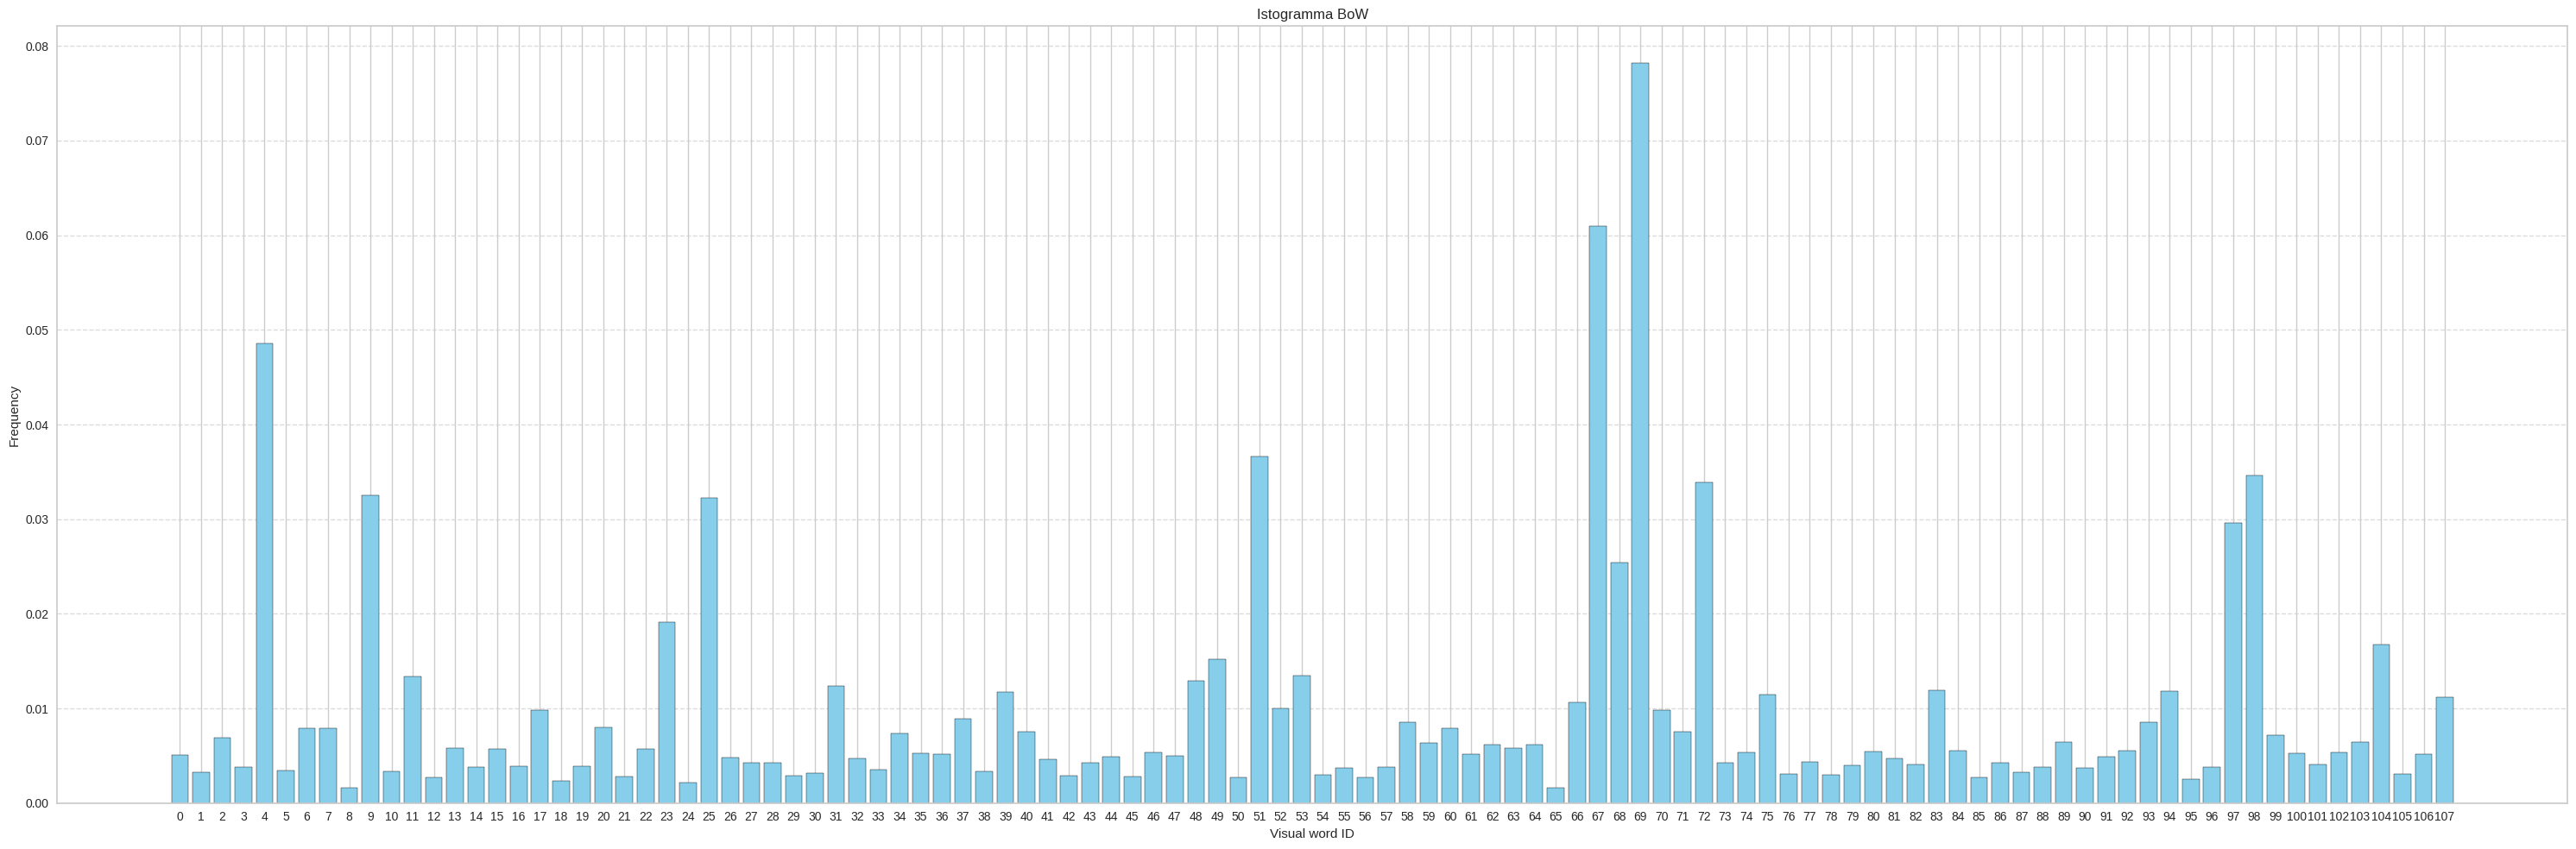

In [ ]:
plot_bow_histogram(soft_hist_training[6])

KKNeighborsClassifier implementation with k = 15 as in assignment 3

In [ ]:
# preprocessing
#label encoding training_labels text-numbers
label_encoder = LabelEncoder()
labels_train_encoded = label_encoder.fit_transform(train_labels)
#shuffle data
indices = list(range(len(train_labels)))
rd.shuffle(indices)
soft_hist_training = [soft_hist_training[i] for i in indices]
labels_train_encoded = [labels_train_encoded[i] for i in indices]
indices_test = list(range(len(test_labels)))
rd.shuffle(indices_test)
soft_hist_test = [soft_hist_test[i] for i in indices_test]
test_labels = [test_labels[i] for i in indices_test]

k = 15, accuracy = 0.3886, macro-F1 = 0.3590


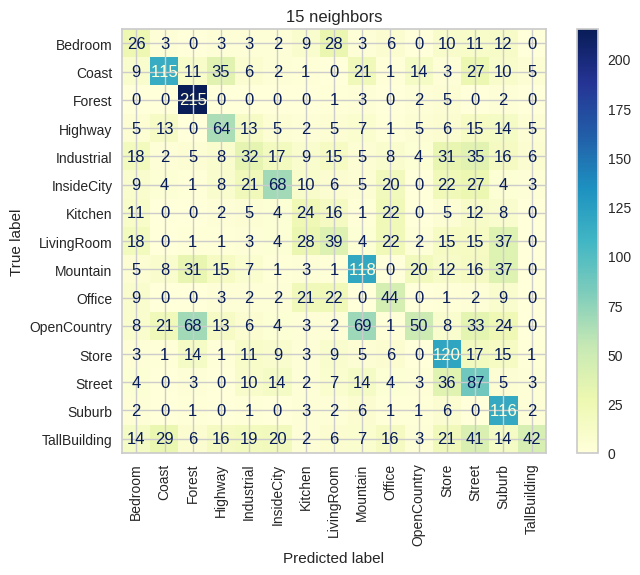

In [ ]:
#training
k= 15
neigh = KNeighborsClassifier(n_neighbors=k) # Mikownski distance
neigh.fit(soft_hist_training, labels_train_encoded)
#test phase
predicted_labels = neigh.predict(soft_hist_test)
# confusion matrix
predicted_labels = label_encoder.inverse_transform(predicted_labels)
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(test_labels, predicted_labels, display_labels=labels,xticks_rotation='vertical',cmap='YlGnBu')
cm_display.ax_.set_title(("{} neighbors").format(k))
acc = accuracy_score(test_labels, predicted_labels)
f1 = f1_score(test_labels, predicted_labels, average='macro')
print(f"k = {k}, accuracy = {acc:.4f}, macro-F1 = {f1:.4f}")

SVM with linear kernel

In [ ]:
# Preprocessing
X_train = np.array(soft_hist_training)
y_train = np.array(train_labels)
X_train, y_train = shuffle(X_train, y_train, random_state=42)
class_names = np.unique(y_train)
n_classes = len(class_names)


classifiers = []
# One-vs-rest
for class_name in class_names:
    # binary target for each class
    y_binary = (y_train == class_name).astype(int)
    svm = SVC(kernel='linear', probability=True)
    svm.fit(X_train, y_binary)
    classifiers.append(svm)


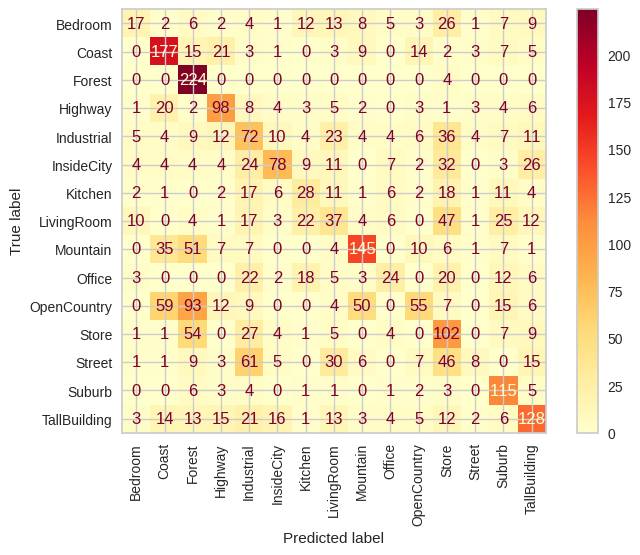

In [ ]:
#test - linear kernel
X_test = np.array(soft_hist_test)
predictions = []
# scores has as rows the test images and as columns the single classifier, transposition is need to find the max value
scores = np.array([clf.decision_function(X_test) for clf in classifiers]).T
for i in range(len(X_test)):
    predicted_label = np.argmax(scores[i])
    predictions.append(predicted_label)
# confusion matrix
y_pred_labels = [class_names[i] for i in predictions]
test_labels = list(test_labels)
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(test_labels,y_pred_labels , display_labels=labels,xticks_rotation='vertical',cmap='YlOrRd')

## Point 9

---

optionally, you could add some spatial information by taking inspiration
from the spatial pyramid feature representation of [Lazebnik et al., 2006]
(a simple approach could be that of building an extended descriptor, by
stacking the histogram of the whole image, the histograms of the 4 quad-
rants and so on, up to a desired level)


###**Comments**

---



The algorithm implements the following steps:
1.  Extract dense features + (x, y) locations
3.  Build histograms per spatial cell at each level
4.  Multiply each histogram by its pyramid weight
5.  Concatenate all histograms into a single vector
6.  Normalize the entire vector by its total mass (sum of bins)
7.  Stack all image vectors into matrix X

In [ ]:

def extract_sift_from_cell(subimg, visual_words):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(subimg, None)
    v = visual_words.shape[0]
    hist = np.zeros(v)

    if descriptors is not None:
      # descriptors: (n, 128), visual_words: (k, 128)
      distances = np.linalg.norm(descriptors[:, np.newaxis, :] - visual_words[np.newaxis, :, :], axis=2) #distances ha dimensioni (n,k)
      # Find for each descriptor the closest visual word
      closest_words = np.argmin(distances, axis=1)
      # Increase the bin = visual word
      for idx in closest_words:
          hist[idx] += 1

    return hist

def spatial_pyramid_per_cell(image, kmeans, vocab_size, max_level=2):
    """
    Extract features by splitting the image into subimages per cell,
    and extracting SIFT independently per cell.
    """
    h, w = image.shape[:2]
    pyramid_vector = []

    for level in range(1,max_level + 1):
        num_cells = 2 ** level
        cell_h = h // num_cells
        cell_w = w // num_cells
        weight = 1.0 / (2 ** (max_level - level))

        for i in range(num_cells):
            for j in range(num_cells):
                y_start = i * cell_h
                y_end = (i + 1) * cell_h if i != num_cells - 1 else h

                x_start = j * cell_w
                x_end = (j + 1) * cell_w if j != num_cells - 1 else w

                cell_img = image[int(y_start):int(y_end), int(x_start):int(x_end)]
                hist = extract_sift_from_cell(cell_img, visual_words)
                pyramid_vector.append(hist * weight)

    # Final concatenated and normalized feature vector
    final_vector = np.concatenate(pyramid_vector)
    total = final_vector.sum()
    if total > 0:
        final_vector /= total

    return final_vector


In [ ]:
# Features extractions for training images
pyramid_training = []
for image_path in images_training:
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    pyramid_vector = spatial_pyramid_per_cell(image, visual_words, 108)
    pyramid_training.append(pyramid_vector)

In [ ]:
# Features extractions for test images
pyramid_test= []
for image_path in images_test:
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    pyramid_vector = spatial_pyramid_per_cell(image, visual_words, 108)
    pyramid_test.append(pyramid_vector)

### **SVM test**


*   Linear Kernel: there is a general improvement in performance, particularly for the *Open Country* and *Street* classes (with more than 120 correct classifications).
*   Rbf Kernel:in this case as well, the classifications of *Open Country* and *Street* improve, but those of *Inside City* and *Mountain* worsen.
*   Poly Kernel: the *Street* and *Store* classes are classified worse compared to the traditional model, but the *Open Country* class, as with the other kernels, is more easily identified. However, overall, the model appears to perform worse.

The *Kitchen* class remains the most difficult to classify even in this case, despite a slight improvement compared to the previous SVM models. On the other hand, the *Open Country* and *Street* classes are classified better than in the previous cases. Despite the different method used to compute the histograms, the models with Gaussian kernels turn out to be among the best for describing the problem, based on the analysis of the confusion matrices.

In [ ]:

# Preprocessing
X_train = np.array(pyramid_training)
y_train = np.array(train_labels)
X_train, y_train = shuffle(X_train, y_train, random_state=42)
class_names = np.unique(y_train)
n_classes = len(class_names)


classifiers_pyramid = []
# One-vs-rest
for class_name in class_names:
    # binary target for each class
    y_binary = (y_train == class_name).astype(int)
    svm = SVC(kernel='rbf', probability=True)
    svm.fit(X_train, y_binary)
    classifiers_pyramid.append(svm)


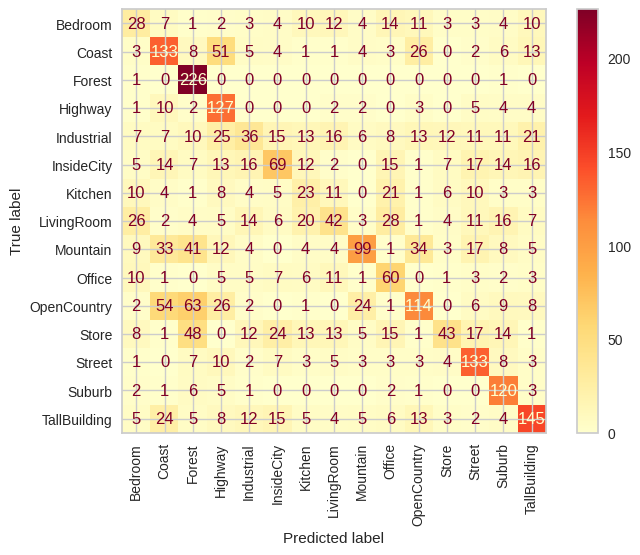

In [ ]:
# test - linear
X_test = np.array(pyramid_test)
predictions = []
# scores has as rows the test images and as columns the single classifier, transposition is need to find the max value
scores = np.array([clf.decision_function(X_test) for clf in classifiers_pyramid]).T
for i in range(len(X_test)):
    predicted_label = np.argmax(scores[i])
    predictions.append(predicted_label)
# confusion matrix
y_pred_labels = [class_names[i] for i in predictions]
test_labels = list(test_labels)
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(test_labels,y_pred_labels , display_labels=labels,xticks_rotation='vertical',cmap='YlOrRd')

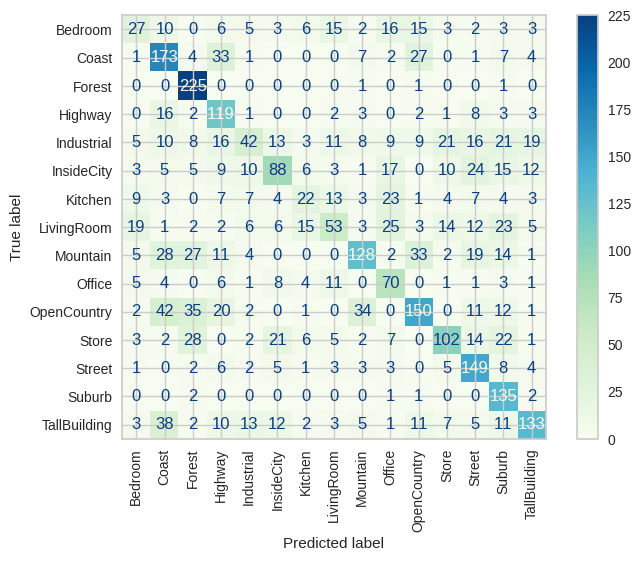

In [ ]:
# test - rbf
X_test = np.array(pyramid_test)
predictions = []
# scores has as rows the test images and as columns the single classifier, transposition is need to find the max value
scores = np.array([clf.decision_function(X_test) for clf in classifiers_pyramid]).T
for i in range(len(X_test)):
    predicted_label = np.argmax(scores[i])
    predictions.append(predicted_label)
# confusion matrix
y_pred_labels = [class_names[i] for i in predictions]
test_labels = list(test_labels)
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(test_labels,y_pred_labels , display_labels=labels,xticks_rotation='vertical',cmap='GnBu')

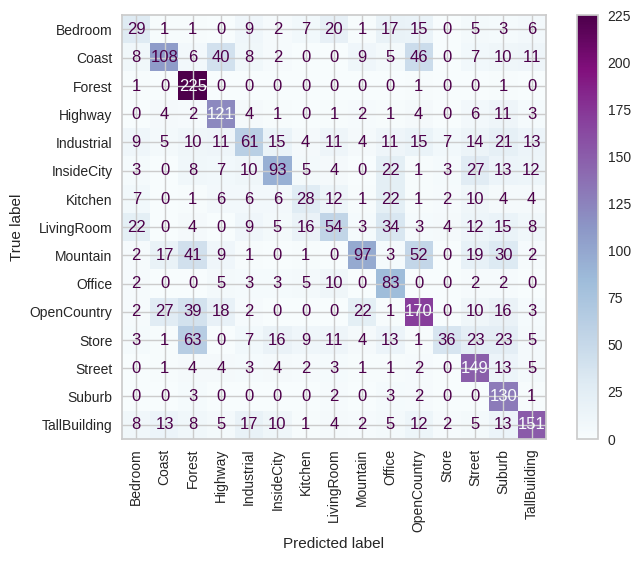

In [ ]:
# test - poly
X_test = np.array(pyramid_test)
predictions = []
# scores has as rows the test images and as columns the single classifier, transposition is need to find the max value
scores = np.array([clf.decision_function(X_test) for clf in classifiers_pyramid]).T
for i in range(len(X_test)):
    predicted_label = np.argmax(scores[i])
    predictions.append(predicted_label)
# confusion matrix
y_pred_labels = [class_names[i] for i in predictions]
test_labels = list(test_labels)
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(test_labels,y_pred_labels , display_labels=labels,xticks_rotation='vertical',cmap='BuPu')